# Sephora Customer Segmentation (Refined)

This notebook performs customer segmentation based on processed customer and product data. The primary goal is to group customers into distinct clusters using relevant features and output a CSV file mapping each `client_id` to a `cluster_id`.

**Key changes in this version:**
* Loads data from `data/processed/reviews.csv` and `data/processed/skincare_product_info.csv`.
* Uses the Silhouette method for determining the optimal number of clusters.
* Emphasizes careful feature engineering and selection for customer segmentation based on provided column names.

The process involves:
1.  Loading pre-processed data.
2.  Merging the processed data.
3.  Engineering features that describe customer behavior and preferences.
4.  Determining optimal cluster count using Silhouette analysis.
5.  Applying K-Means clustering.
6.  Analyzing cluster characteristics.
7.  Exporting the segmentation results.

In [46]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score # For Silhouette analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Define the base path for PROCESSED data
PROCESSED_DATA_PATH = "../data/processed/"

print("Libraries imported and PROCESSED_DATA_PATH set to:", PROCESSED_DATA_PATH)

Libraries imported and PROCESSED_DATA_PATH set to: ../data/processed/


## Cell 3: Load Processed Data & Initial Merge

In [47]:
# This cell loads processed reviews.csv and skincare_product_info.csv, then merges them.
# The output of this cell will be `merged_df`.

print(f"Looking for processed data in: {PROCESSED_DATA_PATH}")

# Define file names
processed_reviews_file = "reviews.csv"
processed_products_file = "skincare_product_info.csv"

reviews_csv_path = os.path.join(PROCESSED_DATA_PATH, processed_reviews_file)
products_csv_path = os.path.join(PROCESSED_DATA_PATH, processed_products_file)

# Load processed reviews data
try:
    reviews_df = pd.read_csv(reviews_csv_path)
    print(f"Successfully loaded {processed_reviews_file}. Shape: {reviews_df.shape}")
    print("Columns in processed reviews_df:", reviews_df.columns.tolist())
    print("\nProcessed Reviews DataFrame Sample:")
    print(reviews_df.head())
except FileNotFoundError:
    print(f"Error: {reviews_csv_path} not found.")
    reviews_df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred loading {processed_reviews_file}: {e}")
    reviews_df = pd.DataFrame()

# Load processed product information
try:
    products_df = pd.read_csv(products_csv_path)
    print(f"\nSuccessfully loaded {processed_products_file}. Shape: {products_df.shape}")
    print("Columns in processed skincare_product_info_df (products_df):", products_df.columns.tolist())
    print("\nProcessed Products DataFrame Sample:")
    print(products_df.head())
except FileNotFoundError:
    print(f"Error: {products_csv_path} not found.")
    products_df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred loading {processed_products_file}: {e}")
    products_df = pd.DataFrame()

# --- Proceed with merging if both DataFrames are loaded ---
if products_df.empty or reviews_df.empty:
    print("\nCannot proceed with merging as one or both processed dataframes are missing/empty.")
    merged_df = pd.DataFrame()
else:
    print("\n--- Starting Data Preprocessing & Merge of Processed Files ---")
    
    # Ensure 'product_id' columns exist and their types match for merging
    if 'product_id' not in reviews_df.columns:
        print("Error: 'product_id' column missing in processed reviews.csv.")
    if 'product_id' not in products_df.columns:
        print("Error: 'product_id' column missing in processed skincare_product_info.csv.")

    if 'product_id' in reviews_df.columns and 'product_id' in products_df.columns:
        products_df['product_id'] = products_df['product_id'].astype(str)
        reviews_df['product_id'] = reviews_df['product_id'].astype(str)

        client_id_col_in_reviews = 'author_id' # As per your reviews.csv schema
        if client_id_col_in_reviews not in reviews_df.columns:
            print(f"Error: Client identifier column '{client_id_col_in_reviews}' not found in reviews.csv.")
            merged_df = pd.DataFrame() # Halt merge
        else:
            reviews_df.dropna(subset=[client_id_col_in_reviews, 'product_id'], inplace=True)
            print(f"Reviews_df shape after dropping NA {client_id_col_in_reviews}/product_id: {reviews_df.shape}")
            
            merged_df = pd.merge(reviews_df, products_df, on="product_id", how="left", suffixes=('_review', '_product'))
            print(f"\nMerged data shape: {merged_df.shape}")
            print("Columns in merged_df after merge:", merged_df.columns.tolist())
            
            # --- Create 'is_on_sale' feature ---
            # Using 'discount_usd_product' from skincare_product_info.csv (after merge)
            # Your skincare_product_info.csv has 'discount_usd'. After merge, it becomes 'discount_usd_product'
            # because 'reviews.csv' also has a 'discount_usd' column.
            discount_column_from_product_info = 'discount_usd_product' 
            if discount_column_from_product_info in merged_df.columns:
                # Ensure the column is numeric before comparison
                merged_df[discount_column_from_product_info] = pd.to_numeric(merged_df[discount_column_from_product_info], errors='coerce')
                merged_df['is_on_sale'] = merged_df[discount_column_from_product_info] > 0
                print(f"Created 'is_on_sale' based on '{discount_column_from_product_info} > 0'.")
            else:
                print(f"Warning: Column '{discount_column_from_product_info}' (expected from skincare_product_info.csv after merge) not found. 'is_on_sale' defaulting to False.")
                merged_df['is_on_sale'] = False
                
            print("\nMerged Data Sample:")
            # Display a few key columns including the client ID, product ID, and the new 'is_on_sale'
            display_cols_sample = [client_id_col_in_reviews, 'product_id', 'is_on_sale']
            # Try to show a price column for context, preferring the one from skincare_product_info
            price_col_for_sample = 'actual_price_usd_product' if 'actual_price_usd_product' in merged_df.columns else ('actual_price_usd_review' if 'actual_price_usd_review' in merged_df.columns else None)
            if price_col_for_sample:
                display_cols_sample.insert(2, price_col_for_sample)
            print(merged_df[display_cols_sample].head())
    else:
        print("Halting merge due to missing 'product_id' columns in one or both dataframes.")
        merged_df = pd.DataFrame()

Looking for processed data in: ../data/processed/


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\3640406453.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_df = pd.read_csv(reviews_csv_path)


Successfully loaded reviews.csv. Shape: (1094411, 34)
Columns in processed reviews_df: ['author_id', 'user_rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'actual_price_usd', 'brand_id', 'discount_usd', 'highlights', 'ingredients', 'limited_edition', 'loves_count', 'new', 'online_only', 'out_of_stock', 'primary_category', 'reviews', 'secondary_category', 'sephora_exclusive', 'size', 'tertiary_category', 'review_length']

Processed Reviews DataFrame Sample:
     author_id  user_rating  is_recommended  helpfulness  \
0   1741593524            5             1.0          1.0   
1  31423088263            1             0.0          NaN   
2   5061282401            5             1.0          NaN   
3   6083038851            5             1.0          NaN   
4  47056667835    

## Cell 4: Feature Engineering & Selection

In [56]:
# This cell takes merged_df (from Cell 3) and engineers customer-level features.
# It then allows for selection of these features for clustering.

if 'merged_df' not in locals() or merged_df.empty:
    print("merged_df is not available from Cell 3. Skipping Feature Engineering & Selection.")
    customer_df = pd.DataFrame() # Ensure defined for later checks
    customer_df_for_clustering = pd.DataFrame() # Ensure defined for later checks
else:
    print("\n--- Starting Feature Engineering (from merged_df) ---")
    
    # --- Step 1: Prepare client identifier ---
    CLIENT_ID_COLUMN_NAME = 'author_id' # From your reviews.csv schema

    if CLIENT_ID_COLUMN_NAME not in merged_df.columns:
        print(f"CRITICAL ERROR: Client ID column '{CLIENT_ID_COLUMN_NAME}' not found in merged_df.")
        print(f"Available columns: {merged_df.columns.tolist()}")
        customer_df = pd.DataFrame()
    else:
        merged_df.dropna(subset=[CLIENT_ID_COLUMN_NAME], inplace=True)
        merged_df[CLIENT_ID_COLUMN_NAME] = pd.to_numeric(merged_df[CLIENT_ID_COLUMN_NAME], errors='coerce')
        merged_df.dropna(subset=[CLIENT_ID_COLUMN_NAME], inplace=True)
        merged_df[CLIENT_ID_COLUMN_NAME] = merged_df[CLIENT_ID_COLUMN_NAME].astype(np.int64)

        # --- Step 2: Define actual source column names from merged_df ---
        # These are based on your provided CSV structures and the merge in Cell 3 (suffixes: '_review', '_product')

        # Features from reviews.csv part of merged_df:
        REVIEW_RATING_COL = 'user_rating' 
        REVIEW_RECOMMENDED_COL = 'is_recommended'
        
        # Features from skincare_product_info.csv part of merged_df
        PRODUCT_PRICE_COL = 'actual_price_usd_product' 
        # CORRECTED LINE BELOW:
        PRODUCT_RATING_COL = 'rating' # Sourced from skincare_product_info.csv. Since 'rating' is not in reviews.csv, it won't get a '_product' suffix.
        PRODUCT_LOVES_COL = 'loves_count_product'      
        PRODUCT_BRAND_COL = 'brand_name_product'      
        PRODUCT_CATEGORY_COL = 'primary_category_product' 
        PRODUCT_LIMITED_EDITION_COL = 'limited_edition_product' 
        PRODUCT_NEW_COL = 'new_product'               
        PRODUCT_ONLINE_ONLY_COL = 'online_only_product' 
        PRODUCT_SEPHORA_EXCLUSIVE_COL = 'sephora_exclusive_product' 
        
        PRODUCT_IS_ON_SALE_COL = 'is_on_sale' # Engineered in Cell 3

        print("\n--- Confirming availability of source columns for features in merged_df ---")
        source_columns_map = {
            REVIEW_RATING_COL: "reviews.csv ('user_rating')",
            REVIEW_RECOMMENDED_COL: "reviews.csv ('is_recommended')",
            PRODUCT_PRICE_COL: "skincare_product_info.csv ('actual_price_usd_product')",
            PRODUCT_RATING_COL: "skincare_product_info.csv ('rating')", # Corrected expected name
            PRODUCT_LOVES_COL: "skincare_product_info.csv ('loves_count_product')",
            PRODUCT_BRAND_COL: "skincare_product_info.csv ('brand_name_product')",
            PRODUCT_CATEGORY_COL: "skincare_product_info.csv ('primary_category_product')",
            PRODUCT_LIMITED_EDITION_COL: "skincare_product_info.csv ('limited_edition_product')",
            PRODUCT_NEW_COL: "skincare_product_info.csv ('new_product')",
            PRODUCT_ONLINE_ONLY_COL: "skincare_product_info.csv ('online_only_product')",
            PRODUCT_SEPHORA_EXCLUSIVE_COL: "skincare_product_info.csv ('sephora_exclusive_product')",
            PRODUCT_IS_ON_SALE_COL: "Engineered in Cell 3 ('is_on_sale')"
        }
        all_source_cols_found = True
        for col_name, col_source_desc in source_columns_map.items():
            if col_name not in merged_df.columns:
                print(f"Warning: Expected source column '{col_name}' (for {col_source_desc}) NOT FOUND in merged_df. Related features will be NaN or cause errors.")
                all_source_cols_found = False
        
        if all_source_cols_found:
            print("All key source columns for feature engineering appear to be available in merged_df.")
        print("--- End of source column confirmation ---\n")
        
        # --- Step 3: Calculate features per customer using groupby().agg() ---
        print("Calculating customer features using groupby().agg()...")
        
        agg_functions = {}
        if REVIEW_RATING_COL in merged_df.columns: agg_functions['avg_rating_given'] = (REVIEW_RATING_COL, 'mean')
        if REVIEW_RECOMMENDED_COL in merged_df.columns: agg_functions['prop_recommended'] = (REVIEW_RECOMMENDED_COL, 'mean')
        agg_functions['num_reviews'] = (CLIENT_ID_COLUMN_NAME, 'count')

        if PRODUCT_PRICE_COL in merged_df.columns:
            agg_functions['avg_price_reviewed'] = (PRODUCT_PRICE_COL, 'mean')
            agg_functions['total_value_reviewed'] = (PRODUCT_PRICE_COL, 'sum')
        if PRODUCT_RATING_COL in merged_df.columns: agg_functions['avg_product_rating_reviewed'] = (PRODUCT_RATING_COL, 'mean') # Uses corrected PRODUCT_RATING_COL
        if PRODUCT_LOVES_COL in merged_df.columns: agg_functions['avg_loves_count_reviewed'] = (PRODUCT_LOVES_COL, 'mean')
        if PRODUCT_BRAND_COL in merged_df.columns: agg_functions['num_unique_brands_reviewed'] = (PRODUCT_BRAND_COL, 'nunique')
        if PRODUCT_CATEGORY_COL in merged_df.columns: agg_functions['num_unique_categories_reviewed'] = (PRODUCT_CATEGORY_COL, 'nunique')
        if PRODUCT_LIMITED_EDITION_COL in merged_df.columns: agg_functions['prop_limited_edition'] = (PRODUCT_LIMITED_EDITION_COL, lambda x: x.astype(float).mean())
        if PRODUCT_NEW_COL in merged_df.columns: agg_functions['prop_new_product'] = (PRODUCT_NEW_COL, lambda x: x.astype(float).mean())
        if PRODUCT_ONLINE_ONLY_COL in merged_df.columns: agg_functions['prop_online_only'] = (PRODUCT_ONLINE_ONLY_COL, lambda x: x.astype(float).mean())
        if PRODUCT_SEPHORA_EXCLUSIVE_COL in merged_df.columns: agg_functions['prop_sephora_exclusive'] = (PRODUCT_SEPHORA_EXCLUSIVE_COL, lambda x: x.astype(float).mean())
        if PRODUCT_IS_ON_SALE_COL in merged_df.columns: agg_functions['prop_on_sale_reviewed'] = (PRODUCT_IS_ON_SALE_COL, lambda x: x.astype(float).mean())
        
        if not agg_functions or not all_source_cols_found:
            print("Error: Not all necessary source columns were found or no valid aggregation functions defined. Cannot create customer_df robustly.")
            customer_df = pd.DataFrame()
        else:
            customer_df = merged_df.groupby(CLIENT_ID_COLUMN_NAME).agg(
                **agg_functions
            ).reset_index()
            customer_df.rename(columns={CLIENT_ID_COLUMN_NAME: 'client_id'}, inplace=True)
            customer_df.set_index('client_id', inplace=True)
            print("Customer features calculated.")

        # --- Parallelization Consideration Comments ---
        # (Keep comments about Dask/multiprocessing here if desired)
        # ---

        if not customer_df.empty:
            print(f"\nCustomer features DataFrame created. Shape: {customer_df.shape}")
            print("Customer DataFrame sample:")
            print(customer_df.head())
            
            # --- Step 4: Feature Selection ---
            print("\nSelecting all available engineered numeric features for clustering as a starting point.")
            actual_features_to_use = customer_df.select_dtypes(include=np.number).columns.tolist()
            
            if not actual_features_to_use:
                 print("Error: No numeric features available after engineering for clustering.")
                 customer_df_for_clustering = pd.DataFrame()
            else:
                customer_df_for_clustering = customer_df[actual_features_to_use].copy()
                print(f"Using these features for clustering: {customer_df_for_clustering.columns.tolist()}")
                print("\nSample of data selected for clustering (customer_df_for_clustering):")
                print(customer_df_for_clustering.head())
                print("\nNaNs per selected feature (before imputation for clustering):")
                print(customer_df_for_clustering.isnull().sum())
        else:
            print("Customer DataFrame is empty after feature engineering attempt.")
            customer_df_for_clustering = pd.DataFrame()
            
if 'customer_df' not in locals():
    customer_df = pd.DataFrame()
if 'customer_df_for_clustering' not in locals():
    customer_df_for_clustering = pd.DataFrame()


--- Starting Feature Engineering (from merged_df) ---



--- Confirming availability of source columns for features in merged_df ---
All key source columns for feature engineering appear to be available in merged_df.
--- End of source column confirmation ---

Calculating customer features using groupby().agg()...
Customer features calculated.

Customer features DataFrame created. Shape: (503195, 14)
Customer DataFrame sample:
           avg_rating_given  prop_recommended  num_reviews  \
client_id                                                    
538863                  1.0               0.0            1   
540761                  2.0               NaN            1   
549704                  5.0               NaN            1   
553815                  5.0               1.0            1   
557770                  5.0               NaN            1   

           avg_price_reviewed  total_value_reviewed  \
client_id                                             
538863                   24.0                  24.0   
540761                   4

## Cell 5: Prepare for Clustering (Imputation & Scaling)

In [57]:
if 'customer_df_for_clustering' not in locals() or customer_df_for_clustering.empty:
    print("Data for clustering is not available. Skipping preparation.")
    processed_customer_df = pd.DataFrame()
else:
    print("\n--- Preparing Data for Clustering (Imputation & Scaling) ---")
    
    features_to_process = customer_df_for_clustering.columns.tolist()
    
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # Impute NaNs
        ('scaler', StandardScaler())                   # Scale features
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, features_to_process)
        ],
        remainder='passthrough'
    )
    
    try:
        processed_features_array = preprocessor.fit_transform(customer_df_for_clustering)
        processed_customer_df = pd.DataFrame(processed_features_array, 
                                             columns=features_to_process, 
                                             index=customer_df_for_clustering.index)
        
        print("\nProcessed (scaled and imputed) customer features for clustering (sample):")
        print(processed_customer_df.head())
        
        if processed_customer_df.isnull().sum().any():
            print("\nWARNING: NaNs found in processed_customer_df AFTER imputation. Check pipeline/data.")
            print(processed_customer_df.isnull().sum())
        else:
            print("\nNo NaNs in processed_customer_df. Ready for clustering.")

    except Exception as e:
        print(f"Error during preprocessing for clustering: {e}")
        processed_customer_df = pd.DataFrame()


--- Preparing Data for Clustering (Imputation & Scaling) ---



Processed (scaled and imputed) customer features for clustering (sample):
           avg_rating_given  prop_recommended  num_reviews  \
client_id                                                    
538863            -2.886145         -2.619047     -0.34405   
540761            -1.998036          0.447318     -0.34405   
549704             0.666291          0.447318     -0.34405   
553815             0.666291          0.447318     -0.34405   
557770             0.666291          0.447318     -0.34405   

           avg_price_reviewed  total_value_reviewed  \
client_id                                             
538863              -0.709753             -0.396608   
540761               0.097613             -0.276115   
549704               0.097613             -0.276115   
553815               0.678916             -0.189360   
557770              -0.580575             -0.377329   

           avg_product_rating_reviewed  avg_loves_count_reviewed  \
client_id                           

## Cell 6: Determine Optimal Number of Clusters (Silhouette Method)

In [58]:
if 'processed_customer_df' not in locals() or processed_customer_df.empty:
    print("Processed customer DataFrame is empty. Skipping Silhouette analysis.")
else:
    print("\n--- Determining Optimal K using Silhouette Method ---")
    silhouette_scores = []
    k_range = range(2, 8) # Adjusted range for potentially faster iteration; expand if needed

    if processed_customer_df.shape[0] < max(k_range) * 10: 
        print(f"Warning: Dataset size ({processed_customer_df.shape[0]}) is small for testing many clusters.")
        # Adjust k_range if dataset is smaller than k_range upper bound
        new_upper_k = max(2, min(7, processed_customer_df.shape[0] // 10 if processed_customer_df.shape[0] // 10 > 1 else 2))
        if new_upper_k < 2 : k_range = [] # Not enough data for even 2 clusters
        else: k_range = range(2, new_upper_k +1)

    if not list(k_range):
        print("Not enough data points or k_range is too small to perform Silhouette analysis. Setting K=3 as default for next step.")
        k_range_for_plot = []
    else:
        k_range_for_plot = list(k_range)
        print(f"Testing K values in range: {k_range_for_plot}")
        for k_val in k_range_for_plot:
            try:
                kmeans_model = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
                cluster_labels_temp = kmeans_model.fit_predict(processed_customer_df)
                
                if len(np.unique(cluster_labels_temp)) > 1 and processed_customer_df.shape[0] > k_val :
                    score = silhouette_score(processed_customer_df, cluster_labels_temp)
                    silhouette_scores.append(score)
                    print(f"Silhouette Score for K={k_val}: {score:.4f}")
                else:
                    print(f"Could not calculate Silhouette Score for K={k_val} (not enough unique clusters ({len(np.unique(cluster_labels_temp))}) or samples). Appending NaN.")
                    silhouette_scores.append(np.nan)
            except Exception as e:
                print(f"Error calculating Silhouette for K={k_val}: {e}. Appending NaN.")
                silhouette_scores.append(np.nan)

    if k_range_for_plot and any(not np.isnan(s) for s in silhouette_scores):
        plt.figure(figsize=(10, 6))
        plt.plot(k_range_for_plot, silhouette_scores, marker='o', linestyle='-')
        plt.title('Silhouette Scores for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.xticks(k_range_for_plot)
        plt.grid(True)
        plt.show()
        
        valid_scores = [s for s in silhouette_scores if not np.isnan(s)]
        valid_k_range = [k_range_for_plot[i] for i, s in enumerate(silhouette_scores) if not np.isnan(s)]
        if valid_scores:
            optimal_k_silhouette = valid_k_range[np.argmax(valid_scores)]
            print(f"Recommended K based on highest Silhouette Score: {optimal_k_silhouette}")
        else:
            print("No valid Silhouette scores to determine optimal K automatically.")
    elif k_range_for_plot:
        print("Silhouette analysis completed, but all scores were NaN. Cannot plot or recommend K.")
    else:
        print("Silhouette analysis skipped due to insufficient data or k_range size.")


--- Determining Optimal K using Silhouette Method ---
Testing K values in range: [2, 3, 4, 5, 6, 7]


KeyboardInterrupt: 

## Cell 7: K-Means Clustering
Based on the Silhouette plot and scores from the previous step (and potentially other domain knowledge), choose a value for `K_CLUSTERS`. The K with the highest Silhouette score is often a good choice, but also consider the interpretability of the clusters.

In [59]:
if 'processed_customer_df' not in locals() or processed_customer_df.empty:
    print("Processed customer DataFrame is empty. Skipping K-Means clustering.")
    customer_df_final_with_clusters = pd.DataFrame() 
else:
    print("\n--- Performing K-Means Clustering ---")
    # !!! SET THIS VALUE BASED ON YOUR SILHOUETTE ANALYSIS (and Elbow if you run it) !!!
    K_CLUSTERS = 14 # Example value, ADJUST AS NEEDED (e.g., optimal_k_silhouette if defined)
    print(f"Using K = {K_CLUSTERS} clusters.")

    if K_CLUSTERS <= 1 or K_CLUSTERS > processed_customer_df.shape[0]:
        print(f"Error: Invalid K_CLUSTERS value ({K_CLUSTERS}) for dataset size {processed_customer_df.shape[0]}. Cannot proceed.")
        customer_df_final_with_clusters = pd.DataFrame()
    else:
        kmeans_final_model = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
        cluster_labels = kmeans_final_model.fit_predict(processed_customer_df)
        
        # Use customer_df_for_clustering (unscaled, selected features) for easier interpretation of cluster means
        customer_df_interpretable = customer_df_for_clustering.copy()
        
        if customer_df_interpretable.isnull().values.any():
            print("Imputing NaNs in customer_df_interpretable for cluster analysis (using median)...")
            for col in customer_df_interpretable.columns:
                if customer_df_interpretable[col].isnull().any():
                    median_val = customer_df_interpretable[col].median()
                    customer_df_interpretable[col].fillna(median_val, inplace=True)
        
        customer_df_final_with_clusters = customer_df_interpretable.copy()
        customer_df_final_with_clusters['cluster_id'] = cluster_labels
        
        print(f"\nCustomers with assigned cluster IDs (sample):")
        display_cols = ['cluster_id'] + customer_df_for_clustering.columns.tolist()[:min(3, len(customer_df_for_clustering.columns))]
        print(customer_df_final_with_clusters[display_cols].head())


--- Performing K-Means Clustering ---
Using K = 14 clusters.


Imputing NaNs in customer_df_interpretable for cluster analysis (using median)...

Customers with assigned cluster IDs (sample):
           cluster_id  avg_rating_given  prop_recommended  num_reviews
client_id                                                             
538863              5               1.0               0.0            1
540761              0               2.0               1.0            1
549704             10               5.0               1.0            1
553815             10               5.0               1.0            1
557770              0               5.0               1.0            1


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\2455128734.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df_interpretable[col].fillna(median_val, inplace=True)


## Cell 8: Analyze Clusters


--- Analyzing Cluster Characteristics ---

Cluster Summary (Mean feature values and size per cluster):
            avg_rating_given  prop_recommended  num_reviews  \
cluster_id                                                    
0                   4.545536          0.983915     1.492071   
1                   1.957752          0.093366     1.519065   
2                   4.303516          0.851099     6.132069   
3                   4.500315          0.944716     1.536332   
4                   4.295437          0.837362     2.142901   
5                   4.464047          0.880387     1.290160   
6                   4.689087          0.983277     1.612694   
7                   4.412265          0.879097     2.130301   
8                   4.460246          0.884790    19.996951   
9                   4.334207          0.903574     1.258101   
10                  4.669516          0.992277     1.467294   
11                  4.282408          0.870807     2.513905   
12            

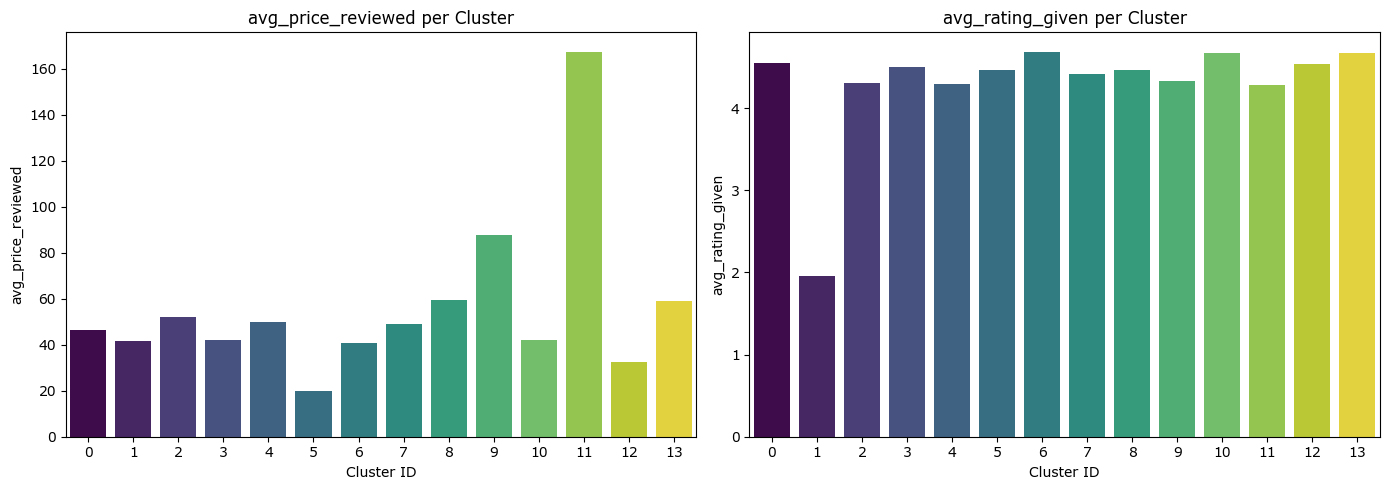

In [60]:
if 'customer_df_final_with_clusters' not in locals() or customer_df_final_with_clusters.empty:
    print("Final customer DataFrame with clusters is not available. Skipping cluster analysis.")
else:
    print("\n--- Analyzing Cluster Characteristics ---")
    cluster_summary = customer_df_final_with_clusters.groupby('cluster_id').mean()
    cluster_sizes = customer_df_final_with_clusters['cluster_id'].value_counts().sort_index()
    cluster_summary['cluster_size'] = cluster_sizes
    
    print("\nCluster Summary (Mean feature values and size per cluster):")
    print(cluster_summary)
    
    # Example: Visualize a couple of key features per cluster
    feature1_to_plot = 'avg_price_reviewed' 
    feature2_to_plot = 'avg_rating_given'   

    available_features_for_plot = [col for col in [feature1_to_plot, feature2_to_plot] if col in cluster_summary.columns]

    if len(available_features_for_plot) > 0:
        num_plots = len(available_features_for_plot)
        fig, axes = plt.subplots(1, num_plots, figsize=(7*num_plots, 5), squeeze=False) 
        
        for i, feature_to_plot in enumerate(available_features_for_plot):
            sns.barplot(x=cluster_summary.index, y=feature_to_plot, data=cluster_summary, ax=axes[0,i], palette="viridis", hue=cluster_summary.index, legend=False) 
            axes[0,i].set_title(f'{feature_to_plot} per Cluster')
            axes[0,i].set_xlabel('Cluster ID')
            axes[0,i].set_ylabel(feature_to_plot)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Note: Example features ('{feature1_to_plot}', '{feature2_to_plot}') not available for plotting cluster summary.")
        print(f"Available features in summary are: {cluster_summary.columns.tolist()}")

## Cell 9: Export Results

In [61]:
if 'customer_df_final_with_clusters' not in locals() or customer_df_final_with_clusters.empty or 'cluster_id' not in customer_df_final_with_clusters.columns:
    print("Clustering was not performed or 'cluster_id' is missing. Skipping export of segments.")
else:
    print("\n--- Exporting Customer Segments ---")
    output_df = customer_df_final_with_clusters[['cluster_id']].reset_index()
    # 'client_id' should be the name of the index after reset_index() if it was named 'client_id'
    if 'index' in output_df.columns and customer_df_final_with_clusters.index.name == 'client_id':
         output_df.rename(columns={'index': 'client_id'}, inplace=True)
    elif customer_df_final_with_clusters.index.name is not None and customer_df_final_with_clusters.index.name != 'client_id':
        output_df.rename(columns={customer_df_final_with_clusters.index.name : 'client_id'}, inplace=True)
    
    output_filename = "customer_segments_refined.csv"
    try:
        output_df.to_csv(output_filename, index=False)
        print(f"Successfully exported refined customer segments to {output_filename}")
        print("Output CSV sample:")
        print(output_df.head())
    except Exception as e:
        print(f"Error exporting CSV: {e}")


--- Exporting Customer Segments ---
Successfully exported refined customer segments to customer_segments_refined.csv
Output CSV sample:
   client_id  cluster_id
0     538863           5
1     540761           0
2     549704          10
3     553815          10
4     557770           0


## Customer Cluster Summaries

---

### **Cluster 0: Contented Loyalists**
* **Size:** 82,734 customers
* **Summary:** Satisfied customers who stick to familiar, moderately priced, popular products and aren't swayed by trends or sales.

---

### **Cluster 1: Disappointed Critics of Popular Goods**
* **Size:** 58,380 customers
* **Summary:** Very critical reviewers of popular, relatively low-priced items, despite the products' general popularity.

---

### **Cluster 2: Engaged Brand Explorers**
* **Size:** 41,327 customers
* **Summary:** Active and generally satisfied reviewers who try a good number of brands and show moderate interest in trends and sales.

---

### **Cluster 3: Online Channel Loyalists**
* **Size:** 43,529 customers
* **Summary:** Highly satisfied customers who predominantly purchase online-only products, often less "viral" items.

---

### **Cluster 4: Limited Edition & Sephora Exclusive Hunters (Sale Savvy)**
* **Size:** 9,678 customers
* **Summary:** Seek out limited editions and Sephora exclusives, and are the most interested in finding these items on sale.

---

### **Cluster 5: Budget Fans of Viral Hits (Sephora Exclusives)**
* **Size:** 18,507 customers
* **Summary:** Purchase very low-priced but extremely popular (viral) items, with a high preference for Sephora exclusives.

---

### **Cluster 6: Devoted Sephora Exclusive Fans**
* **Size:** 63,823 customers
* **Summary:** Highly satisfied, budget-conscious customers who overwhelmingly prefer Sephora exclusive products.

---

### **Cluster 7: New Product Aficionados (High Quality Focus)**
* **Size:** 8,112 customers
* **Summary:** Early adopters who focus on new products that also have high community ratings, often Sephora exclusives or online.

---

### **Cluster 8: High-Spending, Prolific Reviewing Brand Connoisseurs**
* **Size:** 4,263 customers
* **Summary:** Highly engaged customers who spend and review a lot, explore many brands, and show interest in new products.

---

### **Cluster 9: Premium Sale Seekers (Viral Products)**
* **Size:** 10,492 customers
* **Summary:** Purchase high-priced, popular items almost exclusively when they are on sale, often Sephora exclusives.

---

### **Cluster 10: Quality-Focused Budget Buyers**
* **Size:** 123,569 customers
* **Summary:** The largest group; very satisfied, they buy low-priced items that have excellent community ratings and are the least interested in trends or sales.

---

### **Cluster 11: Luxury Niche Loyalists**
* **Size:** 10,212 customers
* **Summary:** Spend the most per item by far, focusing on expensive, niche (less viral) products and are brand loyal.

---

### **Cluster 12: Sephora Exclusive Fans (Less Critical of Product Ratings)**
* **Size:** 27,802 customers
* **Summary:** Strongly prefer Sephora exclusives, similar to Cluster 6, but are satisfied even if those exclusives have lower overall community ratings.

---

### **Cluster 13: Super Reviewers / High-Spending Trendsetters**
* **Size:** 767 customers
* **Summary:** A very small group of power users who review, spend, and explore brands the most, focusing on high-quality, new, and often niche items.

---

## Cell 10: Conclusion & Next Steps (Refined Segmentation)

This notebook has performed customer segmentation using data from `data/processed/`, with an emphasis on careful feature selection and Silhouette analysis for determining the number of clusters. The output is `customer_segments_refined.csv`.

**Interpreting Your Clusters:**
Carefully analyze the `Cluster Summary` table (Cell 8). The key is to identify how the average feature values differ across clusters, defining distinct customer personas. Consider not just the means, but also the relative importance of features that differentiate the groups.

**Potential Next Steps & Improvements:**
* **Iterative Feature Engineering & Selection:** The selection in Cell 4 is crucial. You might iterate on this: try different sets of features, use techniques like PCA for dimensionality reduction, or look at feature importance from predictive models (if applicable to a related task) to guide selection.
* **Hyperparameter Tuning for K-Means:** While `random_state` ensures reproducibility, other parameters of KMeans could be explored.
* **Alternative Clustering Algorithms:** If K-Means results are not satisfactory or its assumptions don't hold, explore DBSCAN, Agglomerative Clustering, etc.
* **Business Validation:** Ultimately, the "best" segmentation is the one that is most actionable and provides meaningful insights for your business goals.